In [2]:
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter

In [3]:
offers_connection = sqlite3.connect('../datasets/offers_dataset.db')
offers_frame = pd.read_sql_query('''SELECT * FROM offers''', offers_connection)
offers_connection.close()
offers_frame

,Name,Description,Location
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria"
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata"
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia"
...,...,...,...
587,Python Software Engineer,Now is an amazing time to join Nozomi Networks...,"Milano, Lombardia"
588,Software Engineer,"Who we are:At Mambu, we believe that banking a...","Provincia di Latina, Lazio"
589,R&D Labeling Principal Engineer,This is where you save and sustain lives \n ...,"Medolla, Emilia-Romagna"
590,Workspace & Endpoint Deployment - System Engineer,Intesa Sanpaolo è un gruppo bancario internazi...,"Milano, Lombardia"


**Presenza di Valori Nulli e Duplicati**
Come è possibile vedere di seguito il dataset contiene valori nulli solo per la colonna Location, il che però è normale, in quanto non tutte le Offerte di lavoro sono in presenza, quindi le Location mancanti rappresentano il numero di Offerte di lavoro in Remote.
Questa informazione è importante perchè in seguito ci sarà la necessità di rappresentare queste informazioni in modo omogeneo, in modo tale che un modello il cui scopo è raggruppare le Offerte (clustering, come proposto nell'Analisi del Problema) possa farlo in modo adeguato.

In [4]:
offers_frame.dropna(subset='Name', inplace=True)
offers_frame.drop_duplicates(inplace=True)
offers_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 586 entries, 0 to 591
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         586 non-null    object
 1   Description  586 non-null    object
 2   Location     542 non-null    object
dtypes: object(3)
memory usage: 18.3+ KB


# Data Preparation
Per permettere il completo soddisfacimento dei requisiti, alcuni dati mancanti alle offerte dovranno essere aggiunti al dataset, tra cui:
- RequiredSkills: le Competenze richieste da una Offerta
- LocationType: il tipo di Location, se in remoto (Remote) o in sede (OnSite)
- Languages: le lingue naturali necessarie per l'offerta di lavoro
- Latitudine e Longitudine: per poter sfruttare la Location bisogna convertirla in Latitudine e Longitudine

## Skill Extraction
L'estrazione delle Competenze, o *skill*, dal dataset delle Offerte è eseguita estraendo le skill richieste dalle descrizioni delle Offerte, facendo riferimento al dataset delle Competenze.
Di seguito viene mostrato il procedimento di estrazione.

In [5]:
from commons import (
    remove_symbols, 
    extract_symbols,
    translate_skills,
    REMOVAL
)

with sqlite3.connect('../datasets/skills_dataset.db') as skills_connection:
    skills_frame = pd.read_sql_query('SELECT * FROM skills', skills_connection)
    skills_frame.set_index('ID', inplace=True)

In [6]:
# Get Skill list
skills_list = [skill.lower() for skill in skills_frame['SKILL'].tolist()]

required_skills = [] 
for i, offer_description in enumerate(offers_frame.loc[:, 'Description']):
    desc = remove_symbols(offer_description, REMOVAL)
    offer_skills = extract_symbols(desc, skills_list)
    required_skills.append(translate_skills(offer_skills, skills_frame, to_id=True))
offers_frame.insert(len(offers_frame.columns), "RequiredSkills", required_skills)

### Pulizia Offerte

In seguito al processo di estrazione abbiamo notato che nel dataset erano presenti Offerte per cui non venivano specificate delle Competenze richieste, questo ci ha permesso di migliorare le procedure di estrazione e di identificare Competenze non contenute nel dataset; nonostante ciò sono rimaste delle Offerte che non richiedevano Competenze, in quanto effettivamente non venivano specificate nella descrizione, in questo caso sono state rimosse dal dataset in quanto il sistema Turing Careers durante il procedimento di creazione di una Offerta richiede a un Datore di Lavoro di inserire obbligatoriamente almeno una Competenza richiesta.
Di seguito viene prima visualizzata la quantità di offerte inutilizzabili ed il viene effettuata la pulizia.

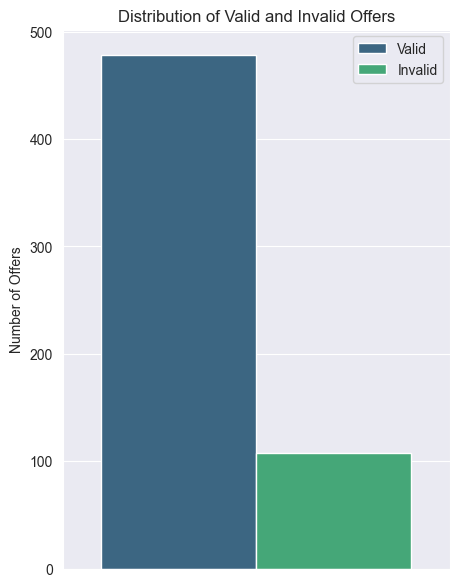

In [7]:
# Original dataset size
length_raw = len(offers_frame)

# Replace empty sets with numpy NaN 
offers_frame['RequiredSkills'] = offers_frame['RequiredSkills'].apply(lambda x: np.NaN if not x else x)

# Number of invalid offers
length_invalid = len(offers_frame[offers_frame['RequiredSkills'].isna()])

# Plot
plt.figure(figsize=(5,7))
offer_quality_plot = sns.barplot(hue=['Valid', 'Invalid'], y=[(length_raw-length_invalid), length_invalid], palette='viridis')
plt.ylabel('Number of Offers')
plt.title('Distribution of Valid and Invalid Offers')
plt.show()

In [8]:
# Remove offers with no required skills
offers_frame.dropna(subset='RequiredSkills', inplace=True)
offers_frame.reset_index(drop=True, inplace=True)

length_processed = len(offers_frame)
offers_frame

,Name,Description,Location,RequiredSkills
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria","{100, 101}"
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,"{2, 6, 7, 8, 9}"
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,"{0, 26, 44, 6}"
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata","{8, 9, 2}"
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia","{0, 1, 99, 6, 7, 104, 57, 26}"
...,...,...,...,...
473,IT On-Site Support Engineer,IT On-Site Support EngineerFunctional area: In...,"Milano, Lombardia",{103}
474,Python Software Engineer,Now is an amazing time to join Nozomi Networks...,"Milano, Lombardia","{89, 73, 2, 30}"
475,Software Engineer,"Who we are:At Mambu, we believe that banking a...","Provincia di Latina, Lazio","{30, 6, 31}"
476,Workspace & Endpoint Deployment - System Engineer,Intesa Sanpaolo è un gruppo bancario internazi...,"Milano, Lombardia",{103}


### Popolarità delle Skill

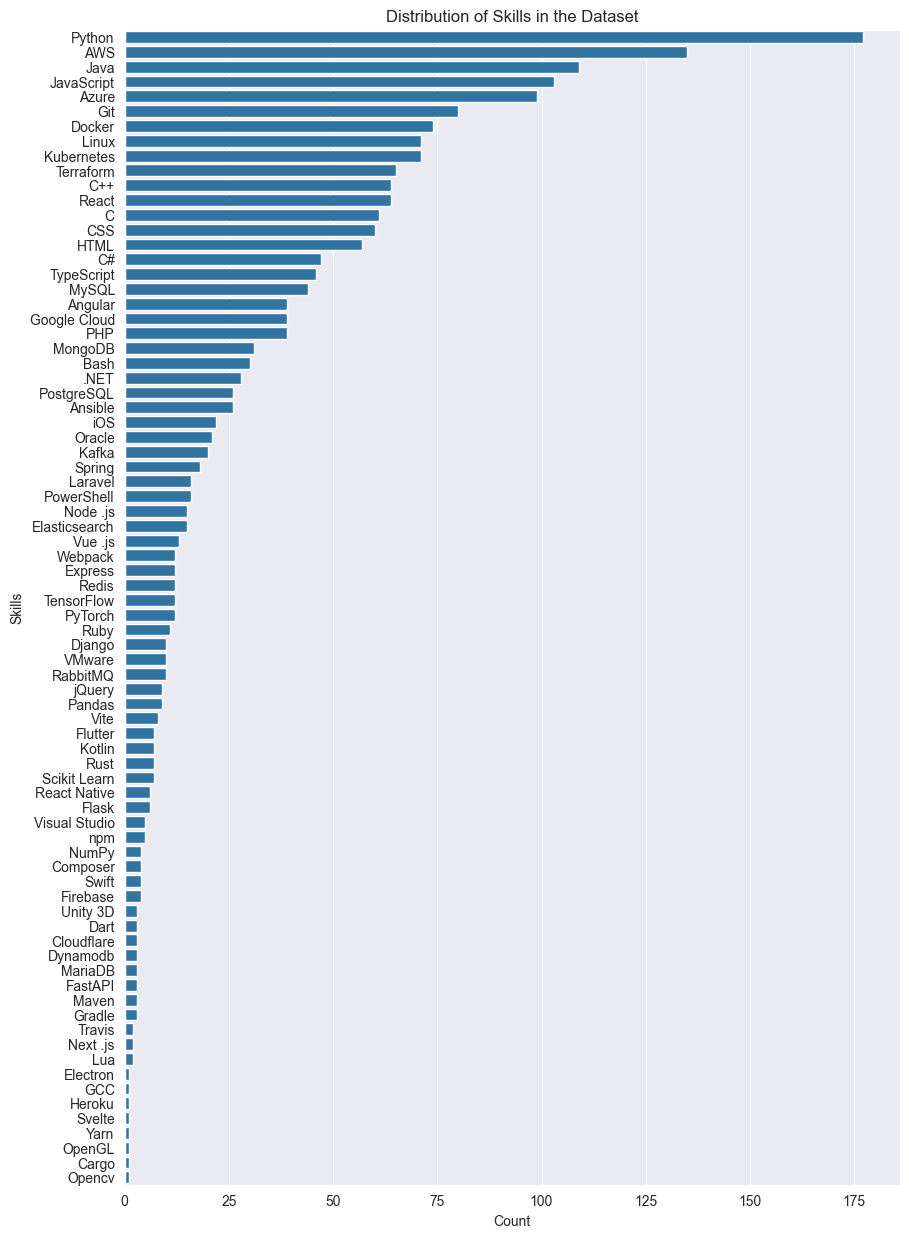

In [9]:
from commons import id_to_skill

# Count
out = []
skill_counts = Counter()
for skill_set in required_skills:
    if skill_set:
        sset = id_to_skill(skill_set, skills_frame)
        out.append(sset)
        for s in sset:
            skill_counts[s] += 1
sorted_counts = {skill: skill_counts[skill] for skill in sorted(skill_counts, key=skill_counts.get, reverse=True)}

# Plot
plt.figure(figsize=(10, 15))
sns.barplot(x=sorted_counts.values(), y=sorted_counts.keys())
plt.title("Distribution of Skills in the Dataset")
plt.xlabel("Count")
plt.ylabel("Skills")
plt.show()

### Distribuzione del numero di skill richieste da ciascuna offerta
Osserviamo la distribuzione del numero di skill richieste da ogni singola offerta nel tentativo di identificare eventuali outliers, offerte che richiedono un numero di skills particolarmente lontano dalla media.

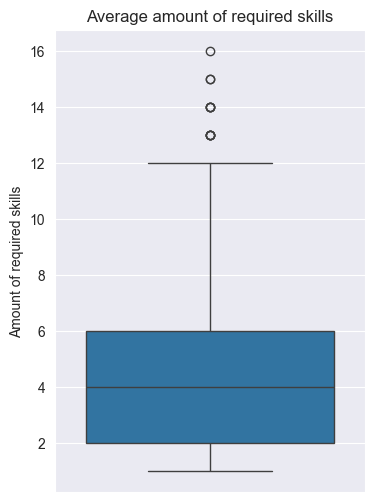

In [10]:
skills_number = []

for sset in offers_frame.loc[:, "RequiredSkills"]:
    skills_number.append(len(sset))

plt.figure(figsize=(4, 6))
plt.title("Average amount of required skills")
plt.ylabel("Amount of required skills")
sns.boxplot(y=skills_number)
plt.show()

Dal grafico si può notare la presenza di alcuni outliers, in particolare le offerte che richiedono un numero di skills maggiore di 12.
Di seguito le offerte outliers: 

In [11]:
tmp_frame = offers_frame["RequiredSkills"].apply(lambda sset: len(sset))
f = []

for v in tmp_frame:
    f.append(v > 12)

outliers = offers_frame.loc[f]
outliers

,Name,Description,Location,RequiredSkills
18,Front-End - App Developer,Siamo alla ricerca di candidati brillanti per ...,"Milano, Lombardia","{0, 65, 68, 4, 100, 103, 41, 44, 47, 17, 26, 3..."
27,Full Stack Developer,Role description: \n \n- Develop new AI produ...,None,"{0, 2, 99, 100, 40, 73, 41, 78, 18, 19, 52, 84..."
106,Backend Developer,"Se sei un/una Developer in gamba, con poca o m...","Napoli, Campania","{0, 1, 99, 4, 100, 40, 73, 10, 44, 19, 53, 21,..."
188,Frontend Developer,About Nexway :Founded in 2002 Nexway has beco...,Nîmes (30),"{0, 1, 32, 99, 4, 100, 40, 73, 41, 80, 21, 24,..."
213,Backend developers,- Modelo retributivo a la carta- Horario flexi...,En remoto,"{0, 1, 2, 99, 4, 100, 6, 10, 14, 19, 52, 53, 2..."
245,Frontend Developer (Vue),The Freepik Universe is Still in Full Expansio...,"29015 Málaga, Málaga provincia","{0, 1, 99, 4, 100, 40, 73, 10, 74, 44, 41, 78,..."
281,Cloud Infrastructure Engineer,Job Description ‍Looking to be part of a team ...,En remoto,"{66, 2, 100, 5, 104, 73, 15, 80, 30, 23, 89, 9..."
285,(Azure) Cloud Solutions Engineer,"If you like this offer, please send your CV me...","Valencia, Valencia provincia","{2, 100, 6, 73, 9, 11, 80, 18, 19, 89, 26, 91,..."
289,Software Engineer,About this positionHere you will be part of on...,"18001 Granada, Granada provincia","{0, 2, 100, 73, 41, 44, 47, 50, 52, 21, 89, 59..."
313,Backend Java Developer,Company DescriptionTHE WORLD OF UBISOFT \n U...,"Barcelona, Barcelona provincia","{0, 100, 6, 104, 73, 42, 43, 47, 80, 19, 83, 2..."


# Tipo di Location
Per estrarre il tipo di Location dalle informazioni attualmente già presenti nel dataset, 
saranno interpretate come di tipo Remote tutte le offerte che non presentano una Location.

In [12]:
# Le Location En-Remoto devono essere trasformate in None
offers_frame["Location"] = offers_frame['Location'].apply(lambda location: np.NaN if location == 'En remoto' else location)

In [13]:
LOCATION_TYPES = {"Remote" : "Remote", "On Site" : "OnSite"}
locations_present = offers_frame["Location"].notna()
types = []

for is_present in locations_present:
    if is_present:
        types.append(LOCATION_TYPES["On Site"])
    else:
        types.append(LOCATION_TYPES["Remote"])

offers_frame.loc[:, "LocationType"] = types

offers_frame

,Name,Description,Location,RequiredSkills,LocationType
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria","{100, 101}",OnSite
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,"{2, 6, 7, 8, 9}",OnSite
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,"{0, 26, 44, 6}",OnSite
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata","{8, 9, 2}",OnSite
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia","{0, 1, 99, 6, 7, 104, 57, 26}",OnSite
...,...,...,...,...,...
473,IT On-Site Support Engineer,IT On-Site Support EngineerFunctional area: In...,"Milano, Lombardia",{103},OnSite
474,Python Software Engineer,Now is an amazing time to join Nozomi Networks...,"Milano, Lombardia","{89, 73, 2, 30}",OnSite
475,Software Engineer,"Who we are:At Mambu, we believe that banking a...","Provincia di Latina, Lazio","{30, 6, 31}",OnSite
476,Workspace & Endpoint Deployment - System Engineer,Intesa Sanpaolo è un gruppo bancario internazi...,"Milano, Lombardia",{103},OnSite


# Lingue Richieste
Per dedurre quali lingue parlate sono richieste da una data offerta di lavoro, viene utilizzato il modulo langdetect per identificare la lingua in cui è stata scritta la descrizione dell'offerta stessa, e successivamente tramite una ricerca all'interno del testo della descrizione per menzioni di ulteriori lingue.

In [14]:
from langdetect import detect
from string import punctuation
offers_langs = []
remove_map = {p:'' for p in punctuation}

eqs = {'it' : ('italiano', 'italian', 'italien', 'italiano'), 
       'en' : ('inglese', 'english', 'anglais', 'inglés'),
       'fr' : ('francese', 'french', 'français', 'francés'),
       'es' : ('spagnolo', 'spanish', 'espagnol', 'español')}

supported_langs = [x for v in eqs.values() for x in v]


for i, desc in enumerate(offers_frame.Description):
    lang = detect(desc)
    
    try:
        lang = eqs[lang][0]
    except KeyError:
        print(f'offer {i} unsupported "{lang}" detected')
        lang = None
    
    desc = remove_symbols(desc, remove_map)
    found = extract_symbols(desc, supported_langs)
    
    found = list(found)
    for i, l in enumerate(found):
        for e in eqs.values():
            if l in e:
                found[i] = e[0]
                break
    
    found = set(found)
    
    if lang is not None:
        found.add(lang)
    offers_langs.append(found)
    
offers_frame.loc[:, "Languages"] = offers_langs

offers_frame

,Name,Description,Location,RequiredSkills,LocationType,Languages
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria","{100, 101}",OnSite,{inglese}
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,"{2, 6, 7, 8, 9}",OnSite,{italiano}
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,"{0, 26, 44, 6}",OnSite,{inglese}
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata","{8, 9, 2}",OnSite,{inglese}
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia","{0, 1, 99, 6, 7, 104, 57, 26}",OnSite,{italiano}
...,...,...,...,...,...,...
473,IT On-Site Support Engineer,IT On-Site Support EngineerFunctional area: In...,"Milano, Lombardia",{103},OnSite,"{italiano, inglese}"
474,Python Software Engineer,Now is an amazing time to join Nozomi Networks...,"Milano, Lombardia","{89, 73, 2, 30}",OnSite,{inglese}
475,Software Engineer,"Who we are:At Mambu, we believe that banking a...","Provincia di Latina, Lazio","{30, 6, 31}",OnSite,{inglese}
476,Workspace & Endpoint Deployment - System Engineer,Intesa Sanpaolo è un gruppo bancario internazi...,"Milano, Lombardia",{103},OnSite,"{italiano, inglese}"


## Distribuzione delle Lingue Richieste

Per verificare che il dataset fornisca una buona rappresentazione della realtà è sempre buona norma verificare la distribuzione dei dati, in alcuni casi, per la natura del problema, è impossibile avere un campionario bilanciato e bisogna ricorrere a tecniche *estreme* per ottenere un dataset la cui distribuzione non generi bias nei modelli di Machine Learning applicati, nel nostro caso invece basta ritornare alla fase di collezione dei dati; per questo motivo di seguito viene mostrata la distribuzione delle Lingue Richieste da una offerta. 

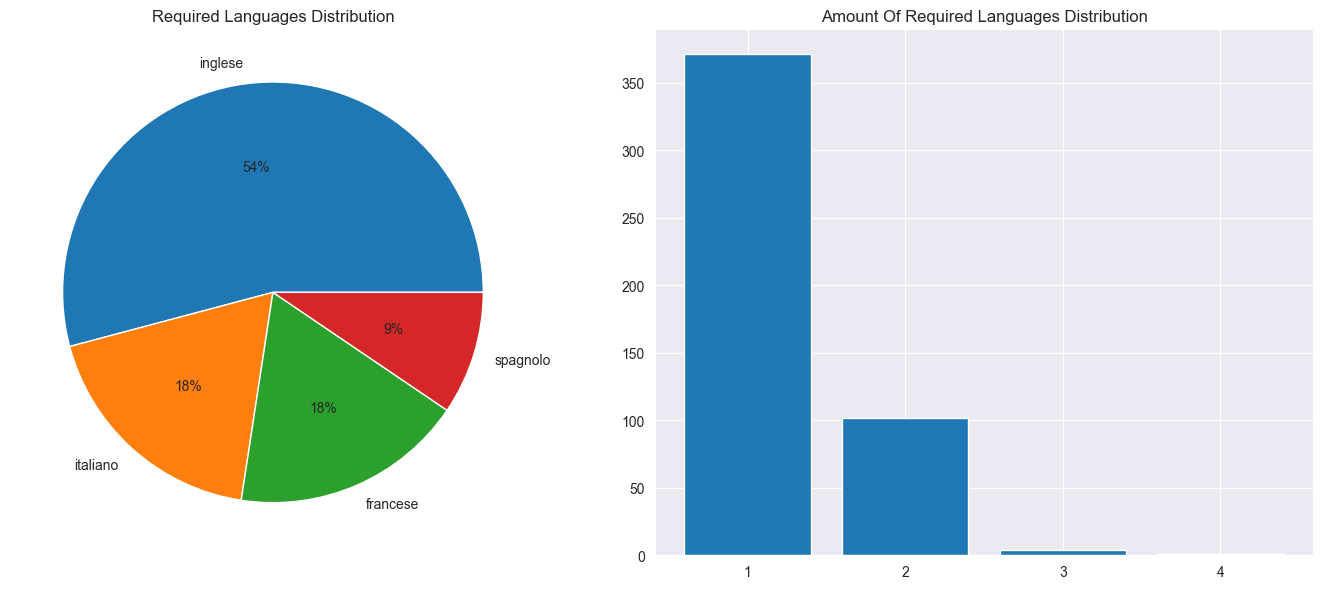

In [15]:
# The count is executed given the assumption that the Required Languages can be Italian or English
language_counter = Counter()
language_number_counter = Counter()
for offer_languages in offers_frame.loc[:, 'Languages']:
    for l in set(offer_languages):
        language_counter[l] += 1
            
    language_number_counter[len(offer_languages)] += 1
    
# Pie chart for Required Languages Distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title('Required Languages Distribution')
plt.pie(language_counter.values(), labels=language_counter.keys(), autopct='%0.f%%')

# Bar chart for Amount Of Required Languages Distribution
plt.subplot(1, 2, 2)
plt.title('Amount Of Required Languages Distribution')
plt.bar(['1', '2', '3', '4'], language_number_counter.values())

plt.tight_layout()  # To prevent overlapping of subplots
plt.show()

# Latitudine e Longitudine delle Location

In [16]:
from commons import get_coordinates

# Compute Latitude and Longitude for each Offer 
offers_frame['Latitude'] = 0.0
offers_frame['Longitude'] = 0.0

for index, row in offers_frame.iterrows():
    try:
        if row['Location']:
            lat, lon = get_coordinates(row['Location']).values()
            offers_frame.loc[index, 'Latitude'] = lat
            offers_frame.loc[index, 'Longitude'] = lon
    except Exception:
        pass
 
offers_frame

,Name,Description,Location,RequiredSkills,LocationType,Languages,Latitude,Longitude
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria","{100, 101}",OnSite,{inglese},0.0,0.0
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,"{2, 6, 7, 8, 9}",OnSite,{italiano},0.0,0.0
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,"{0, 26, 44, 6}",OnSite,{inglese},0.0,0.0
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata","{8, 9, 2}",OnSite,{inglese},0.0,0.0
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia","{0, 1, 99, 6, 7, 104, 57, 26}",OnSite,{italiano},0.0,0.0
...,...,...,...,...,...,...,...,...
473,IT On-Site Support Engineer,IT On-Site Support EngineerFunctional area: In...,"Milano, Lombardia",{103},OnSite,"{italiano, inglese}",0.0,0.0
474,Python Software Engineer,Now is an amazing time to join Nozomi Networks...,"Milano, Lombardia","{89, 73, 2, 30}",OnSite,{inglese},0.0,0.0
475,Software Engineer,"Who we are:At Mambu, we believe that banking a...","Provincia di Latina, Lazio","{30, 6, 31}",OnSite,{inglese},0.0,0.0
476,Workspace & Endpoint Deployment - System Engineer,Intesa Sanpaolo è un gruppo bancario internazi...,"Milano, Lombardia",{103},OnSite,"{italiano, inglese}",0.0,0.0


In [17]:
import folium
EUROPE = [51.5074, -0.1278]

offers_map = folium.Map(location=EUROPE, zoom_start=4)

for index, row in offers_frame.iterrows():
    if row['LocationType'] != 'Remote':
        tooltip_text = f'<b>{row["Name"]}</b>'
        folium.Marker(
            [row['Latitude'], row['Longitude']], 
            tooltip=row['Location'],
            popup=tooltip_text
        ).add_to(offers_map)

offers_map

# Export
Di seguito viene esportato il dataset aggiornato per poter lavorare in modo più veloce nella fase di modeling.

In [18]:
# Convert RequiredSkills and Languages
def set_to_string(item_set):
    return ', '.join(map(str, item_set))

offers_frame['RequiredSkills'] = offers_frame['RequiredSkills'].apply(set_to_string)
offers_frame['Languages'] = offers_frame['Languages'].apply(set_to_string)

offers_frame

,Name,Description,Location,RequiredSkills,LocationType,Languages,Latitude,Longitude
0,Software Developer,Miniclip is a global leader in digital games w...,"Genova, Liguria","100, 101",OnSite,inglese,0.0,0.0
1,Junior Software Developer,"NETtoWORK, azienda italiana nata nel 2016, ope...",17100 Savona,"2, 6, 7, 8, 9",OnSite,italiano,0.0,0.0
2,Software Developer,We are looking for talented and passionate peo...,55100 Lucca,"0, 26, 44, 6",OnSite,inglese,0.0,0.0
3,Software Developer,ARESYS is a R&D oriented company with nearly ...,"Matera, Basilicata","8, 9, 2",OnSite,inglese,0.0,0.0
4,Senior Software Developer,Il/la Candidato/a dovrà padroneggiare: \n \n- ...,"Catania, Sicilia","0, 1, 99, 6, 7, 104, 57, 26",OnSite,italiano,0.0,0.0
...,...,...,...,...,...,...,...,...
473,IT On-Site Support Engineer,IT On-Site Support EngineerFunctional area: In...,"Milano, Lombardia",103,OnSite,"italiano, inglese",0.0,0.0
474,Python Software Engineer,Now is an amazing time to join Nozomi Networks...,"Milano, Lombardia","89, 73, 2, 30",OnSite,inglese,0.0,0.0
475,Software Engineer,"Who we are:At Mambu, we believe that banking a...","Provincia di Latina, Lazio","30, 6, 31",OnSite,inglese,0.0,0.0
476,Workspace & Endpoint Deployment - System Engineer,Intesa Sanpaolo è un gruppo bancario internazi...,"Milano, Lombardia",103,OnSite,"italiano, inglese",0.0,0.0


In [19]:
# Persist
with sqlite3.connect('../datasets/offers_full.db') as export_conn:
    export_curs = export_conn.cursor()
    export_conn.execute(
        '''
        CREATE TABLE IF NOT EXISTS offers (
            Name TEXT,
            Description TEXT,
            Location TEXT,
            RequiredSkills TEXT,
            LocationType TEXT,
            Languages TEXT,
            Latitude REAL,
            Longitude REAL
        )
        '''
    )
    
    export_conn.commit()
    
    offers_frame.to_sql('offers', export_conn, if_exists='append', index=False)